# The curse of dimensionality

In general, we don't want to learn with an arbitrarily large number of features.

We can still improve on the 2 or 3 variables in a lot of 'standard' modeling tasks (e.g. modeling facies from a few logs, or porosity from facies, or permeability from porosity). But the earth is massively high-dimensional... what's the right number, and why does it matter?

- High-dimensional models are hard to explain.
- High-dimensional datasets are hard to visualize.
- We need a lot of data to properly sample the joint distributions of high-dimensional datasets. 
- We're more likely to have redundant features in the data.

🙌 **This notebook was inspired and informed by Rudy Rucker's _The Fourth Dimension and How to Get There_, Richard Hamming's [ADSE book](https://en.wikipedia.org/wiki/The_Art_of_Doing_Science_and_Engineering), Michael Pyrcz's talk on the curse of dimensionality, and my colleague Floris Elzinga's talk at Equinor's developer conference in 2024. Cheers!**

## The unit square

Although the unit square (hypercube really) has constant volume ($= 1^d$ where $d$ is the number of dimensions), **its diagonal is unbounded.** In other words, high-dimensional spaces are BIG.

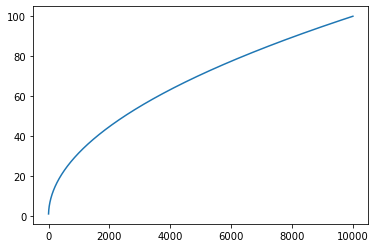

In [3]:
import matplotlib.pyplot as plt
import numpy as np

diag = [np.linalg.norm(np.ones(dim)) for dim in range(1, 10000)]
    
plt.plot(diag)

## Sampling hyperspace

It's big, so it's hard to sample.

Let's say we are training a machine learning model. The features of the data are physical measurements about rocks; maybe one of them is the density of that rock. And imagine that, looking at the distribution of the densities of our rocks, we feel like we can make a decent model if our samples 'cover' 90% of the distribution.

So if we have two features, and we have sampled 80% of their respective distributions, then how much of the joint distribution have we sampled? Well, if the properties are independent, then it's $0.8 \times 0.8 = 0.64$, or 64% of the distribution.

How much of the joint distribution have we sampled if we have 100 features?

In [40]:
100 * 0.8 ** 100

2.0370359763344975e-08

Only 0.00000002%, that's not much!

What does this mean for the amount of data collection we need to do? Well, let's say it took 10 equally-spaced samples to represent that 80% of the distribution for one feature. Then 2 features will require $10^2 = 100$ samples and **100 features is going to need a googol samples**. I probably cannot afford to collect that much data.

Fortunately, our features are usually not independent, or there are structures in the data we can exploit. But the basic point is that you are going to need a lot of samples and/or smart sampling methods for high-dimensional problems. 

## Volume of unit ball

The unit hypercube always has the same volume: 1. But the volume of the unit ball varies quite a bit:

- In 1D it is 2. It's the length of the diameter, basically, since the 'ball' is just a line.
- In 2D it is $\pi r^2$, so $\pi$ since $r = 1$.
- In 3D it is $\tfrac{4}{3} \pi$
- In 4D and above, we'll need a function to compute it...

For radius $R$ in $d$ dimensions:

$$ V_d(R) = \frac{\pi^{d/2}}{\Gamma\bigl(\tfrac d2 + 1\bigr)}R^d$$

Let's use this to compute how the volume varies as a function of dimensionality:

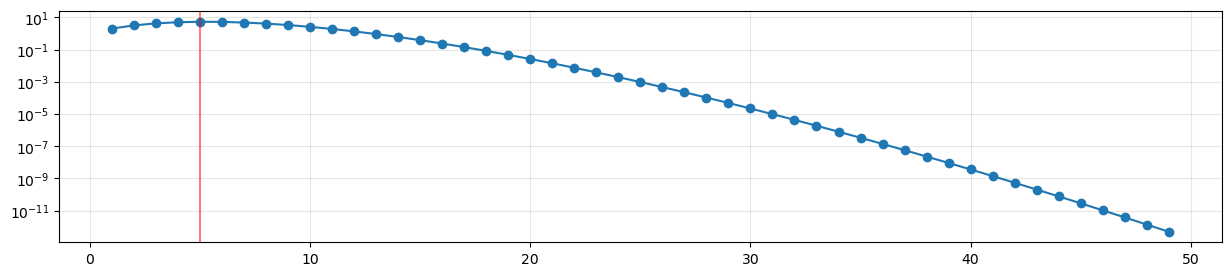

In [47]:
from scipy.special import gamma

def vol(d, r=1):
    return r**d * np.pi**(d/2) / gamma(d/2 + 1)

d = np.arange(1, 50)
vols = vol(d)
maxx = np.argmax(vols) + 1

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(d, vols, 'o-')
ax.axvline(maxx, c='r', alpha=0.5)
ax.set_yscale('log')
ax.grid(c='k', alpha=0.1)
plt.show()

So the unit ball has maximum volume of 5.26 in 5 dimensions. Above that, ball's volume _decreases_, and with only 100 dimensions its volume is already tiny: $2.4 \times 10^{-40}$. Amazing.

In [24]:
vol(100)

np.float64(2.368202101882829e-40)

**So high-dimensional spheres enclose almost no space.** Yet the circumscribed hypercube of side 2 (i.e. the cube that contains the unit ball) grows exponentially in volume:

- 1D: 2
- 2D: 2 &times; 2 = 4 square units
- 3D: 2 &times; 2 &times; 2 = 8 cubic units
- etc.

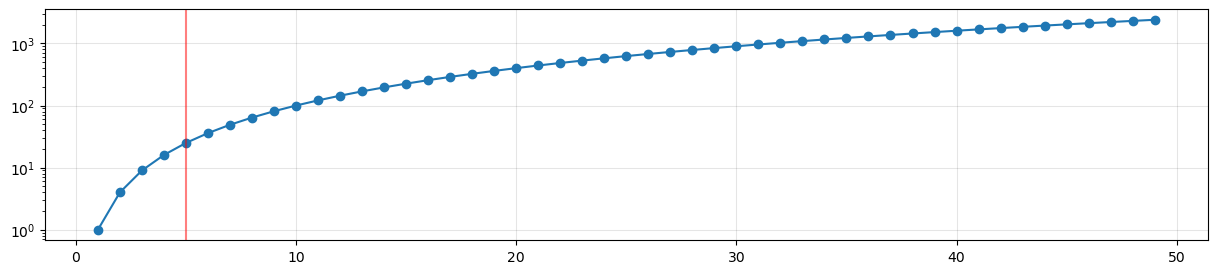

In [26]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(d, d**2, 'o-')
ax.set_yscale('log')
ax.grid(c='k', alpha=0.1)
plt.show()

To put it another way, **the volume of the hypercube is all in the corners**. And a 100-dimensional hypercube has a lot of corners!

In [27]:
2**100

1267650600228229401496703205376

## The volume is in the shell

What proportion of the unit 3D sphere's volume is within 0.01 of the surface?

In [53]:
def vol_frac(d, s):
    return (vol(d, r=1) - vol(d, r=(1 - s))) / vol(d, r=1)

vol_frac(d=3, s=0.01)

np.float64(0.02970100000000011)

Only about 3% in a 3-dimensional sphere.

But in 100 dimensions, 63% of the volume is in this "1% shell":

In [56]:
vol_frac(d=100, s=0.01)

np.float64(0.6339676587267707)

## Distance between points

High dimensional space is BIG (see _The unit square_, above).

One consequence of this is that **random points in the unit cube become very far apart**.

But what is really strange is that **these random points are approximately equally distant from each other**.

So a high dimensional predictive model, i.e. one with a lot of parameters, might struggle to discriminate between samples: everything is far apart, and everything is about the same distance apart. This is one reason why KNNs are less useful for data with a lot of features (like images).

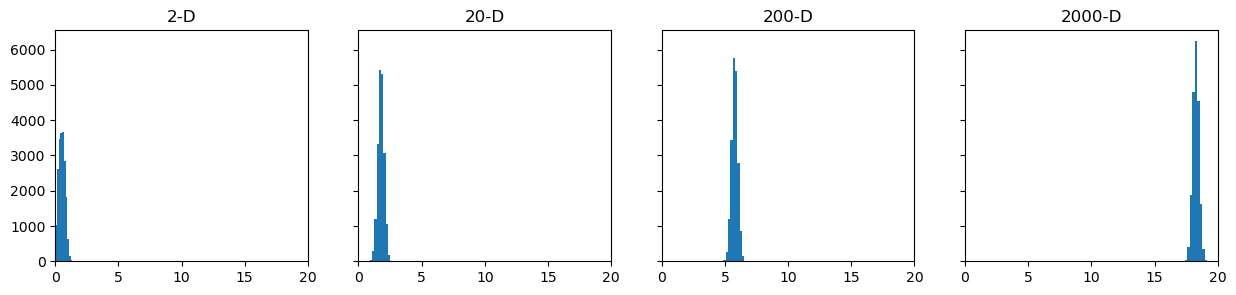

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def dists(dim, n=1000, scale=1):
    X = np.random.random(size=(n, dim))
    return pdist(X)

dims = [2, 20, 200, 2000]

fig, axs = plt.subplots(ncols=len(dims), figsize=(15, 3), sharey=True)

for dim, ax in zip(dims, axs):
    d = dists(dim=dim, n=200)
    ax.hist(d)
    ax.set_xlim(0, 20)
    ax.set_title(f'{dim}-D')

## The inscribed hypersphere

A famous 'experiment' is to inscribe a circle between 4 unit circles:

![image](https://media.cheggcdn.com/media/241/241d8144-ba5c-4ca8-9ecc-fbdbbf720152/phpMYRRRJ)

Then to imagine how the radius of this inscribed circle depends on the dimensionality of the problem.

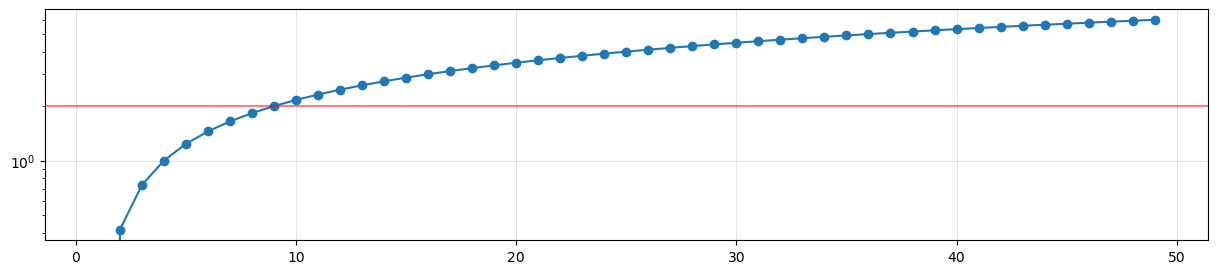

In [60]:
def inscribed_r(d):
    return np.sqrt(d) - 1

radiuses = inscribed_r(d)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(d, radiuses, 'o-')
ax.axhline(2, c='r', alpha=0.5)
ax.set_yscale('log')
ax.grid(c='k', alpha=0.1)
plt.show()

The bizarre thing is that at about 10 dimensions, **the radius of the inscribed hypersphere extends _beyond_ the 'enclosing' unit hypersheres!** And although it might look asymptotic in this plot, it is unbounded.

This seems very strange, until you remember that the space is 'spiky': the volume is in the corners.

Richard Hamming says in his book that a consequence of this is that you might need to look quite far from the average values to find optimal solutions to high-dimensional design problems, since the volume of the design space near the mean is basically 0.

---

&copy; 2024 Matt Hall, licensed CC BY, please re-use this work.